# Display Matched Molecules
See the molecules which are closest in context in our known set from both the "relevant" and "random" populations

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from pymongo import MongoClient
from rdkit.Chem import Draw
from rdkit import Chem
import pandas as pd

Configuration

In [2]:
to_run_per_target = 4  # How many baseline structures to test
match_type = 'abs-cosine'

## Load the Matches
They are stored in CSV files produced by Zhi Hong. Get the top molecules out of Each

In [3]:
relevant = pd.read_csv(f'matched/25apr23-partial-PRD/Known_Pareto-Relevant_ENA-molecules-{match_type}-all.csv')
top_relevant = relevant.sort_values('Cosine Similarity').groupby('Known Pareto Molecule').tail(to_run_per_target)
print(f'Loaded {len(top_relevant)} molecules')

Loaded 28 molecules


In [4]:
random = pd.read_csv(f'matched/25apr23-partial-PRD/Known_Pareto-Random_Valid-molecules-{match_type}-all.csv')
top_random = random.sort_values('Cosine Similarity').groupby('Known Pareto Molecule').tail(to_run_per_target)
print(f'Loaded {len(top_random)} molecules')

Loaded 28 molecules


## Get their Smiles Strings
Look that up from the database

In [5]:
client = MongoClient(port=27894)
coll = client['cfree']['molecule_record']

Get them via projection

In [6]:
def find_smiles(key):
    """Get the record matching a certain InChI Key and return the smiles"""
    return coll.find_one({'_id': key})['identifier']['smiles']

In [7]:
top_random.head(1)

,Known Pareto Molecule,Cosine Similarity,Random Valid Molecule
233,UFWIBTONFRDIAS-UHFFFAOYSA-N,0.526907,KYNSBQPICQTCGU-UHFFFAOYSA-N


In [8]:
for data in [top_relevant, top_random]:
    for col in data.columns[[0, 2]]:
        data[f'{col}-SMILES'] = data[col].apply(find_smiles)

## Plot the Properties
Make a wt%H2 vs storage energy plot

Pull the values from the database

In [9]:
known_molecules = pd.read_csv('../screen-search-space/to-compare.smi', names=['smiles'])
known_molecules['key'] = known_molecules['smiles'].apply(Chem.MolFromSmiles).apply(Chem.MolToInchiKey)

In [10]:
def _extract(record: dict) -> dict:
    output = {'id': record['_id']}
    output.update(record['identifier'])
    output.update(record['property'])
    return output

In [11]:
known_props = pd.DataFrame(map(_extract, coll.find({'_id': {'$in': known_molecules['key'].tolist()}}, projection=['property', 'identifier'])))

In [12]:
random_props = pd.DataFrame(map(_extract, coll.find({'_id': {'$in': top_random.iloc[:, 2].tolist()}}, projection=['property', 'identifier'])))
print(f'Pulled {len(random_props)} SuperBERT molecules')

Pulled 19 SuperBERT molecules


In [13]:
relevant_props = pd.DataFrame(map(_extract, coll.find({'_id': {'$in': top_relevant.iloc[:, 2].tolist()}}, projection=['property', 'identifier'])))
print(f'Pulled {len(relevant_props)} SuperBERT molecules')

Pulled 27 SuperBERT molecules


In [14]:
%%time
baseline_relevant_props = pd.DataFrame(filter(
    lambda x: x['id'] not in set(relevant_props['id']),
    map(_extract, coll.find({'subsets': 'relevant-ENA', 'property.storage_eng': {'$exists': True}}, projection=['property', 'identifier']))
))
print(f'Pulled {len(baseline_relevant_props)} baseline molecules')

Pulled 73 baseline molecules
CPU times: user 106 ms, sys: 54.4 ms, total: 161 ms
Wall time: 6min 21s


In [15]:
%%time
baseline_random_props = pd.DataFrame(filter(
    lambda x: x['id'] not in set(random_props['id']),
    map(_extract, coll.find({'subsets': 'random-valid', 'property.storage_eng': {'$exists': True}}, projection=['property', 'identifier']))
))
print(f'Pulled {len(baseline_random_props)} baseline molecules')

Pulled 68 baseline molecules
CPU times: user 67.2 ms, sys: 31.3 ms, total: 98.5 ms
Wall time: 3min 53s


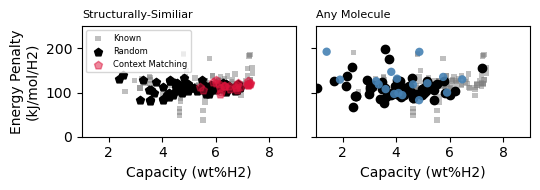

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(5.5, 2.), sharey=True)

# Make the two uniform
for ax in axs:
    ax.scatter(known_props['wt%H2'], known_props['storage_eng'], label='Known', marker='s', color='gray', s=15, alpha=0.5, edgecolor='none')    
    ax.set_xlabel('Capacity (wt%H2)')
    ax.set_xlim([1, 9])
    ax.set_ylim([0, 250])
axs[0].set_ylabel('Energy Penalty\n(kJ/mol/H2)')


# Plot the random molecules
ax = axs[1]
ax.set_title('Any Molecule', fontsize=8, loc='left')
ax.scatter(baseline_random_props['wt%H2'], baseline_random_props['storage_eng'], label='Random', marker='o', color='black')
ax.scatter(random_props['wt%H2'], random_props['storage_eng'], label='SuperBERT+Random', marker='o', color='steelblue', alpha=0.9, edgecolor='none')

# Plot the SuperBERT-selected molecules
ax = axs[0]
ax.set_title('Structurally-Similiar', fontsize=8, loc='left')
ax.scatter(baseline_relevant_props['wt%H2'], baseline_relevant_props['storage_eng'], label='Random', marker='p', color='black')
ax.scatter(relevant_props['wt%H2'], relevant_props['storage_eng'], label='Context Matching', marker='p', color='crimson', alpha=0.5)

ax.legend(fontsize=6)
fig.tight_layout()
fig.savefig('figures/selection-comparison.png', dpi=320)